In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090a_hw4.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science: 
## Homework 4: Classification: Predicting College Admissions

**Harvard University**<br/>
**Fall 2024**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai

<hr style="height:2.4pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

<div style = "background: lightgreen; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should include labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with slighlty longer output. Avoid excessively long output.
- Feel free to add additional code or markdown cells as needed.
- Don't forget to include a written response when one is requested by a question prompt.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

### Import Libraries

In [3]:
# RUN THIS CELL
import itertools
import math
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

In [4]:
# For calculating total notebook runtime
notebook_start = time.time()

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Data exploration using train and basic models**](#part1)

- [**Question 2: Interpretable modeling**](#part2)

- [**Question 3: Harvard and Yale?**](#part3)

- [**Question 4: Building predictive models for admitted**](#part4)

- [**Question 5: Evaluating results**](#part5)

- [**Question 6: BONUS!**](#part6)

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)

### Predicting admissions into elite universities

In this problem set we will model the chances of high school students being accepted into two different elite undergraduate colleges: Harvard and Yale.

The data are provided in the file `data/college_admissions.csv` and were scraped in 2022 from [collegedata.com](https://www.collegedata.com/) (where applicants volunteer to share their information).  Each observation corresponds to an applicant to one of the two different colleges (note: the same applicant may show up in two rows: once for each college).  The main response is the `"admitted"` variable (1 = admitted, 0 = denied), and there are are several predictors to consider:

- **id**: a unique identifier for the applicant 
- **test_score**: a standardized measurement of the applicant's highest ACT or SAT combined score (2400 is the maximum)
- **ap**: the number of AP tests taken
- **avg_ap**: the average score on the AP tests taken (0 if no tests were taken)
- **sat_subjects**: the number of SAT subject tests taken
- **gpa**: the unweighted GPA of the applicant (max of 4.0)
- **female**:  a binary indicator for gender: 1 = female, 0 = otherwise
- **minority**: a binary indicator for under-represented minority: 1 = minority, 0 = otherwise 
- **international**: a binary indicator for international status: 1 = international, 0 = United States
- **sports**: a binary indicator for High School All-American: 1 = all-American athlete, 0 = otherwise
- **harvard**: a categorical variable for school applied to: 1 = Harvard, 0 = Yale
- **early_app**: a binary indicator for application type: 1 = early action, 0 = regular
- **alumni**:  a binary indicator for parents' alumni status of school: 1 = a parent is an alumnus, 0 = otherwise
- **program**: the program applied to by the student with many choices (we will not use this as a predictor)
- **add_info**: additional (optional) info provided by applicant (we will not use this as a predictor)

**The main set of 12 predictors is:**

```python
[
    "test_score", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]
```

Please note, you may need to modify this list when fitting different models.


**IMPORTANT NOTES:**

- Unless stated otherwise, all logistic regression models should be unregularized (use `penalty=None`) and include the intercept (which is the default in `sklearn`).


- When printing your output (e.g. coefficients, accuracy scores, etc.), DO NOT just print numbers without context. Please be certain provide clarifying labels for all printed numbers and limit the number of digits showing after decimals to a reasonable length (e.g. 4 decimal points for coefficients and accuracy scores).


- Also be sure to practice good data science principles: always use train to do analysis and never touch the test set until the very end.

---

<a id="part1"></a>

## <div class='exercise'>Question 1: Data exploration using train and basic models</div>

[Return to contents](#contents)

The first step is to split the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). It also prints the dataset's shape before splitting and after splitting. 

**IMPORTANT:** While an argument could be made to scale our predictors here, please **DO NOT** do so **UNTIL** it is requested of you in **[Question 4.1](#part4)**.


In [5]:
#############################
## DO NOT MODIFY THIS CODE ##
#############################
np.random.seed(121)

college = pd.read_csv("data/college_admissions.csv")

college_train, college_test = train_test_split(
    college,
    test_size=0.2,
    random_state=121,
    shuffle=True,
    stratify=college["admitted"],
)

print(college.shape)
print(college_train.shape, college_test.shape)
display(college_train.head())
college_train.info()

# Separate predictors from response
X_train, y_train = college_train.drop(columns=["admitted"]), college_train["admitted"]
X_test, y_test = college_test.drop(columns=["admitted"]), college_test["admitted"]

(1871, 16)
(1496, 16) (375, 16)


,id,admitted,test_score,ap,avg_ap,sat_subjects,gpa,female,minority,international,sports,early_app,alumni,program,add_info,harvard
192,NYFN0GE0KK,1,2310,7,5.000,5,3.98,0,0,0,0,0,0,Economics,Activities Activity Position Honors Grade Levels Approximate Time When Participated Participate ...,1
652,50FWDZ3MBF,1,2010,3,4.333,3,3.75,1,1,0,0,0,0,History Political Science,Drama Club Co founder of a Community Outreach Organization called Los Amigos volunteered helped ...,1
593,KYYHQRHBV9,0,2080,5,4.200,2,3.85,0,0,0,0,0,0,Biology Pre Med,moderate a few sports and clubs and a part time jobfamily circumstances positive,1
331,JQ8O4AV4VM,0,2250,0,0.000,2,4.00,0,0,0,0,0,0,Physics,NaN,1
1117,SJUQZVBA7K,0,2230,4,4.000,5,3.96,1,0,0,0,1,0,Chemistry Chemical Engineering,MUN Advisor 12 10 National Honors Society 12 10 California Scholarship Federation 12 9 Book Club...,0


<class 'pandas.core.frame.DataFrame'>
Index: 1496 entries, 192 to 1296
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1496 non-null   object 
 1   admitted       1496 non-null   int64  
 2   test_score     1496 non-null   int64  
 3   ap             1496 non-null   int64  
 4   avg_ap         1496 non-null   float64
 5   sat_subjects   1496 non-null   int64  
 6   gpa            1496 non-null   float64
 7   female         1496 non-null   int64  
 8   minority       1496 non-null   int64  
 9   international  1496 non-null   int64  
 10  sports         1496 non-null   int64  
 11  early_app      1496 non-null   int64  
 12  alumni         1496 non-null   int64  
 13  program        1298 non-null   object 
 14  add_info       949 non-null    object 
 15  harvard        1496 non-null   int64  
dtypes: float64(2), int64(11), object(3)
memory usage: 198.7+ KB


<div class='exercise-r'>

**Q1.1** Consider a baseline, "naive" model that predicts that *ALL* applicants belong to the same class. This class prediction is *not* determined by an applicant's feature values, but rather by the proportion of observations in the training data belonging to each class.

Calculate the accuracy of this naive model on the training data and store it in `naive_train_acc`.
    
**NOTE:** For this assignment, use the convention that accuracies range from 0 to 1 (to be consistant with sklearn).
    
</div>

In [6]:
# your code here
mode = y_train.mode()[0]
naive_train_acc = (y_train == mode).mean()

In [7]:
print("Naive Classification Model Based on Training Proportions")
print(f"\tTrain Accuracy: {naive_train_acc:.4f}")

Naive Classification Model Based on Training Proportions
	Train Accuracy: 0.7299


In [8]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.2** Let's investigate how each of our 12 predictors is associated with whether or not an applicant is admitted into the college to which they applied (`admitted`). To this end, create a separate **visual** for each of our predictors to investigate their relationship with college admissions. **Suggestion:** Place these 12 visuals in a grid of subplots with 3 columns and 4 rows.

</div>

In [9]:
# Create dummy variable
train_dummies = pd.get_dummies(college_train, drop_first=True)

#define predictors and exclude 'target variable'
predictors = train_dummies.drop(columns=['admitted']).columns

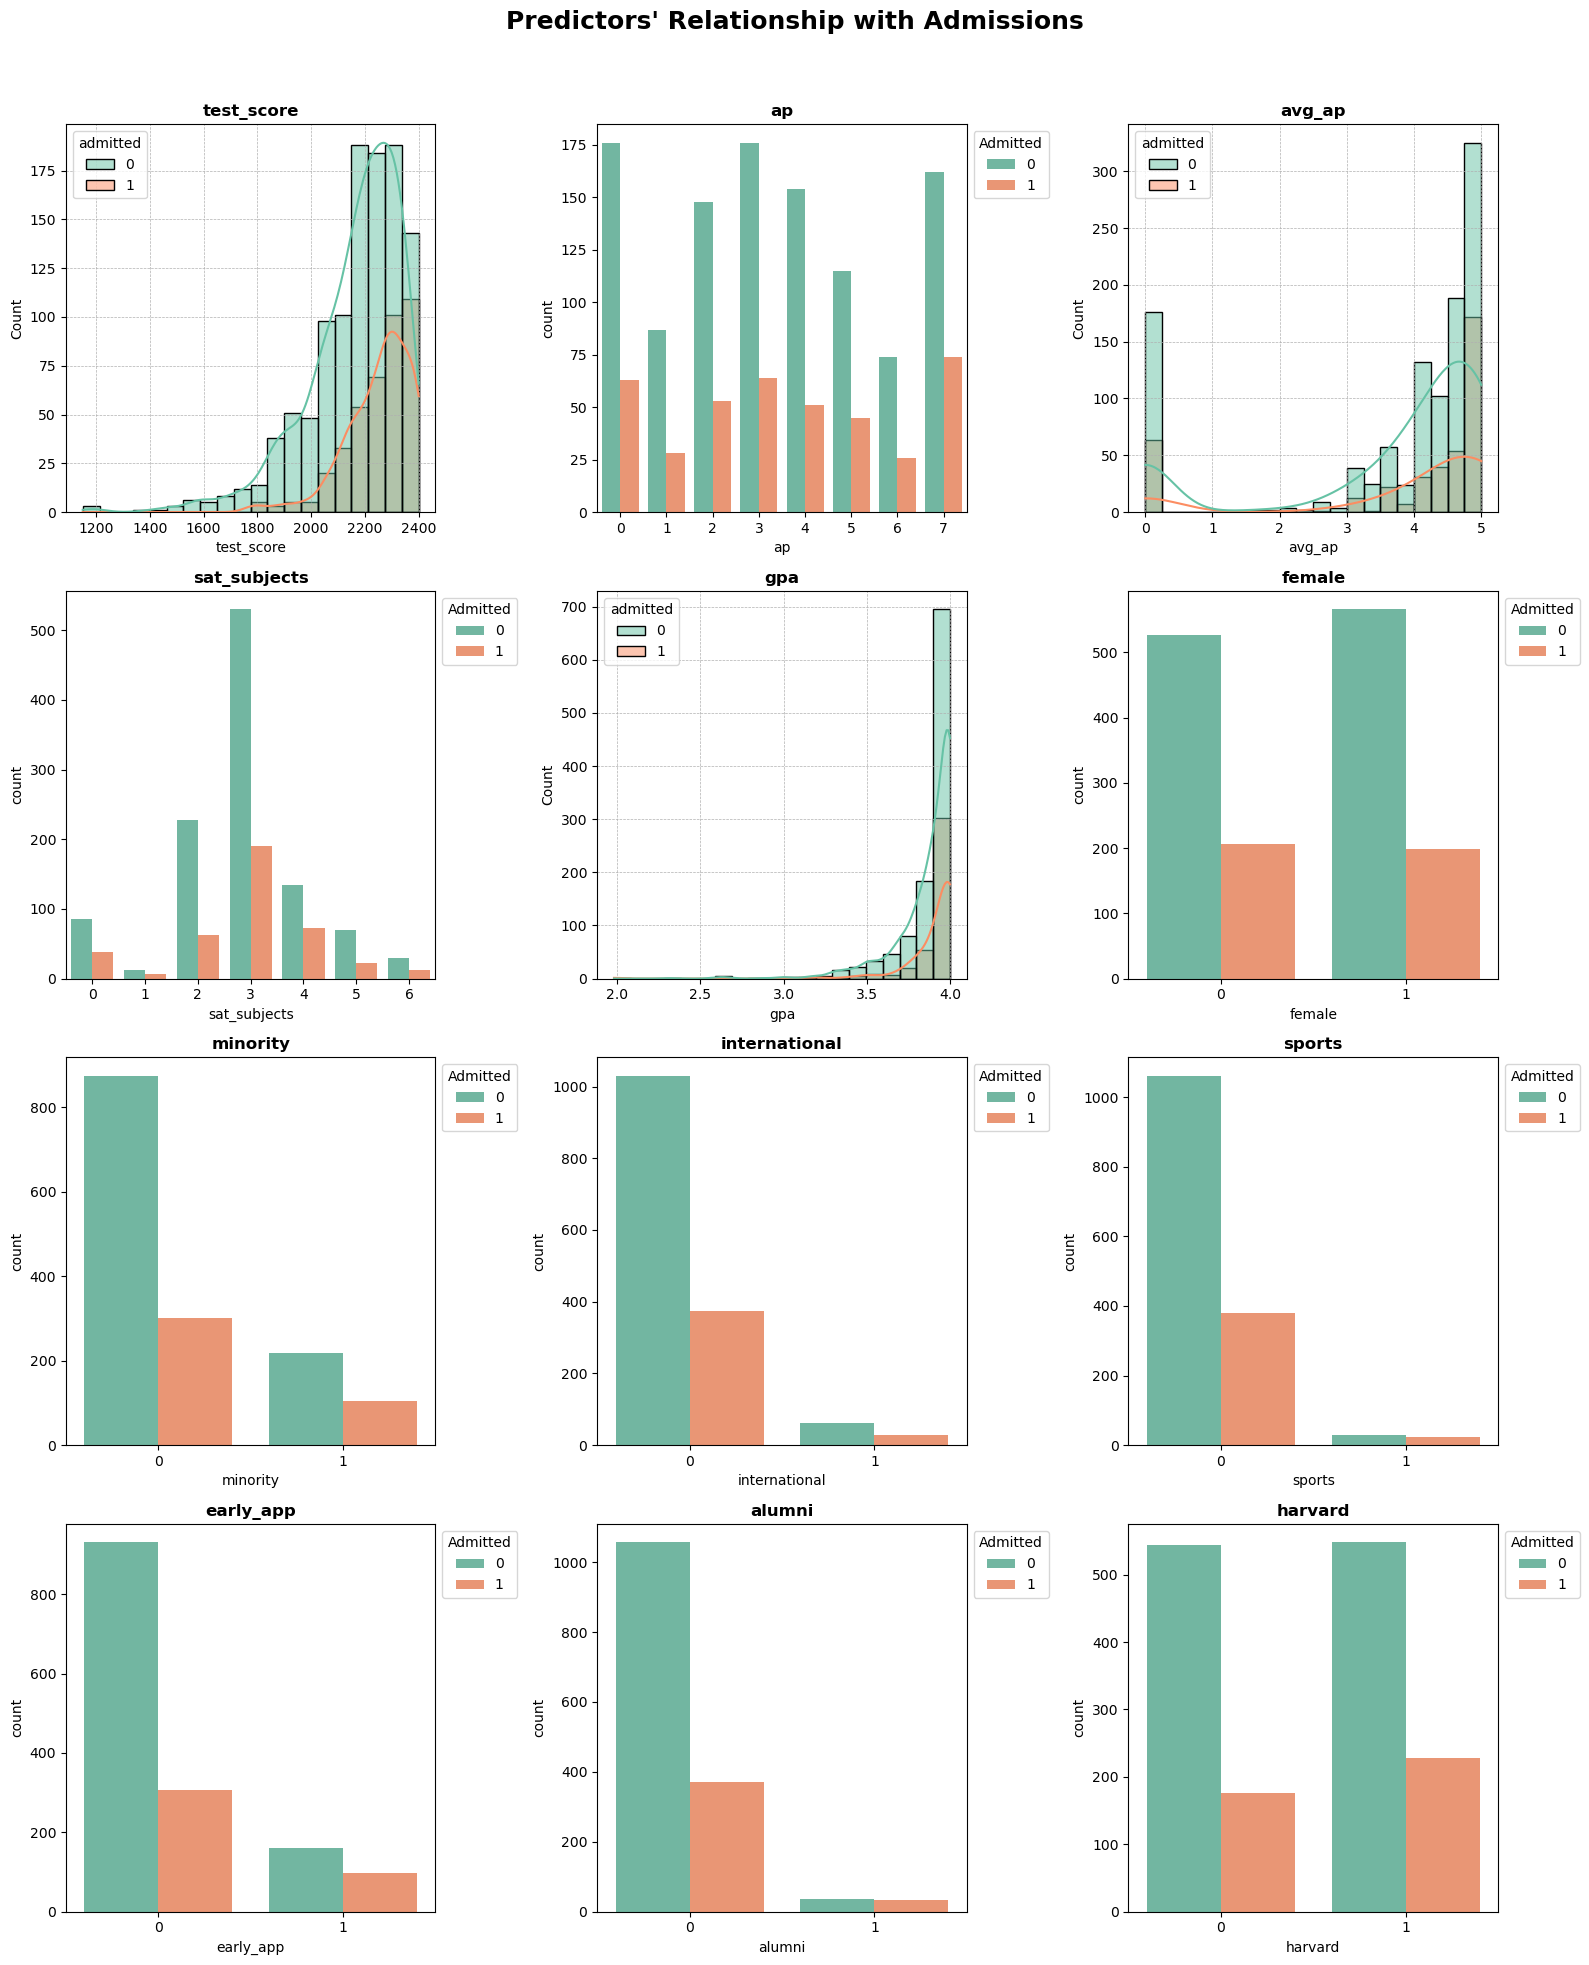

In [10]:
fig, axes = plt.subplots(4, 3, figsize=(16, 20))
fig.suptitle("Predictors' Relationship with Admissions", fontsize=18, fontweight='bold')

# Custom color palette
sns.set_palette("Set2")


axes = axes.flatten()


for i, predictor in enumerate(predictors):
    if i >= len(axes): 
        break
    if train_dummies[predictor].nunique() > 10:  
        sns.histplot(data=train_dummies, x=predictor, hue='admitted', kde=True, ax=axes[i], bins=20, edgecolor='black')
        axes[i].grid(True, linestyle='--', linewidth=0.5)
    else:  
        sns.countplot(data=train_dummies, x=predictor, hue='admitted', ax=axes[i])

    axes[i].set_title(predictor, fontsize=12, fontweight='bold')
    handles, labels = axes[i].get_legend_handles_labels()
    if len(handles) > 0:
        axes[i].legend(title='Admitted', loc='upper left', bbox_to_anchor=(1, 1))

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.3** Based on the visuals above, which predictor seems to have the most potential for predicting `admitted`? Why do you think this it the best potential single predictor?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

1. Test Scores: The graph shows that students with higher test scores are more likely to be admitted, though the difference isn’t as strong as with GPA.

2. Early Application (early_app): Applying early seems to boost admission chances, possibly because it shows a student’s commitment, and universities often like to lock in strong candidates early.

3. Alumni Status (alumni): Students with parents who went to the university tend to have better chances of getting in, reflecting the common practice of legacy admissions.

4. AP and SAT Subject Tests (ap, sat_subjects): Taking more AP and SAT subject tests might signal a student’s academic drive and readiness, traits that top universities appreciate. Those who take more of these tests usually have a stronger academic foundation, which could improve their chances of admission.

5. Harvard vs. Yale (harvard): This variable helps distinguish between the two universities. Each might have its own unique admissions criteria or priorities, which could affect which students they choose to admit.

6. Minority Status (minority): Minority students might have different admission rates, likely influenced by efforts to promote diversity. The graph shows some variation here, suggesting this factor could be important in certain cases.

7. Sports: Being a standout high school athlete, like an All-American, can be an advantage, especially at schools that value sports. While it might not be as critical as GPA or test scores, it’s still a meaningful factor for some applicants.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>
    
**Q1.4** Fit a logistic regression to predict `admitted` from `harvard` (call it `logit1_4`).  
- Store the coefficient and intercept in `logit1_4_coef` and `logit1_4_intercept`. Interpret these values.
- Use $\LaTeX$ to demonstrate how you can use these coefficient values to calculate the estimated probabilities of getting into each school.
- Store the results of the above calculation in `p_harvard` and `p_yale`. 
- Which school is easier to get into according to this model?

**IMPORTANT:** 
- Remember, all models in this assignment should be **unregularized** unless you are specifically asked to use regularization for a particular model.
- Use `random_state = 109` for all of your `LogisticRegression` and `LogisticRegressionCV` models in this notebook.
</div>

In [ ]:
# your code here

# Separate predictors and response
X = college_train[['harvard']]
y = college_train['admitted']


# Fit logistic regression model without regularization
logit1_4 = LogisticRegression(random_state= 109, penalty= None, solver='lbfgs')
# fit the regression
logit1_4.fit(X, y)


# report coefficients & intercept
logit1_4_coef = logit1_4.coef_[0][0]
logit1_4_intercept = logit1_4.intercept_[0]


# Calculate and report probabilities
p_harvard = 1 / (1 + np.exp(-(logit1_4_intercept + logit1_4_coef * 1)))  

# for Yale
p_yale = 1 / (1 + np.exp(-(logit1_4_intercept + logit1_4_coef * 0)))  


In [12]:
print(
    "The coefficient for the 'logit1_4' model's only predictor 'harvard' "
    "is {:.4f} and the intercept is {:.4f}\n".format(
        logit1_4_coef, logit1_4_intercept
    )
)

print(
    "Estimated probability of acceptance for Harvard: {:.4f}"
    .format(p_harvard)
)
print(
    "Estimated probability of acceptance for Yale: {:.4f}"
    .format(p_yale)
)

The coefficient for the 'logit1_4' model's only predictor 'harvard' is 0.2512 and the intercept is -1.1280

Estimated probability of acceptance for Harvard: 0.2938
Estimated probability of acceptance for Yale: 0.2445


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

#### Which school is easier to get into according to this model?


Coefficient (0.1878): This indicates that applying to Harvard increases the log-odds of admission compared to Yale. However, since the value is relatively small, the difference in admission probability between the two schools is modest.

Intercept (-1.0952): This represents the baseline log-odds of admission when applying to Yale (harvard = 0).

, Harvard appears slightly easier to get into, as it has a higher estimated probability of admission. However, the difference between Harvard and Yale is small.
Using merely 1 predictor diesn't predict well on the admission.


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [13]:
grader.check("q1.4")

q1.4 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.5** Create and display a [contingency table](https://en.wikipedia.org/wiki/Contingency_table) between `admitted` and `harvard`.  Use this table to calculate and confirm the coefficient estimates in the `logit1_4` model (both the intercept and slope). Show this calculation using $\LaTeX$ in a markdown cell.
    
**Hint:** The Pandas [crosstab](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html) method may be helpful here.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

From the contingency table, we calculate the log-odds for admission into Harvard and Yale.

##### Contingency Table:
\
\begin{array}{|c|c|c|}
\hline
\text{Admitted} & \text{Yale (0)} & \text{Harvard (1)} \\
\hline
0 & 667 & 699 \\
1 & 223 & 282 \\
\hline
\end{array}

To calculate the slope (coefficient for the harvard predictor) and the intercept in logistic regression, we need to compute the log-odds.
First, we need to calculate the probability of being admitted as Harvard and Yale.

- Probability of being admitted as "Harvard":
  $$
  P(\text{admit}=1 \mid \text{harvard}=1) = \frac{282}{699 + 282} = \frac{282}{981} \approx 0.2874
  $$
  
- Probability of being admitted as "Yale":
  $$
  P(\text{admit}=1 \mid \text{harvard}=0) = \frac{223}{667 + 223} = \frac{223}{890} \approx 0.2506
  $$



#### Then we calculate the Log-Odds.

- Log-odds for `Harvard`:
  $$
  \text{Log-Odds}(\text{harvard}=1) = \ln \left( \frac{P(\text{admit}=1 \mid \text{harvard}=1)}{1 - P(\text{admit}=1 \mid \text{harvard}=1)} \right)
  $$
  $$
  = \ln \left( \frac{0.2874}{1 - 0.2874} \right) = \ln \left( \frac{0.2874}{0.7126} \right) \approx -0.909
  $$

- Log-odds for "Yale":
  $$
  \text{Log-Odds}(\text{harvard}=0) = \ln \left( \frac{P(\text{admit}=1 \mid \text{harvard}=0)}{1 - P(\text{admit}=1 \mid \text{harvard}=0)} \right)
  $$
  $$
  = \ln \left( \frac{0.2506}{1 - 0.2506} \right)  \approx -1.099
  $$




#### Now we calculate the Coefficient


- **Slope (Coefficient for `harvard`)**:
  $$
  \beta_{\text{harvard}} = \text{Log-Odds}(\text{harvard}=1) - \text{Log-Odds}(\text{harvard}=0)
  $$
  $$
  = -0.909 - (-1.099) = 0.19
  $$




#### Intercept
we directly use and assign harvard = 0

  $$
  \beta_0 = \text{Log-Odds}(\text{harvard}=0) \approx -1.099
  $$



#### Conclusion:

- **Slope**: 0.19
- **Intercept**: -1.10

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [14]:
# your code here
# step1: 
contingency_table = pd.crosstab(college['admitted'], college['harvard'])
display(contingency_table)

# srtep2: Calculate probabilities from the contingency table
# Probability of being admitted to Harvard and Yale
p_admit_harvard = contingency_table.loc[1, 1] / contingency_table[1].sum()
p_admit_yale = contingency_table.loc[1, 0] / contingency_table[0].sum()

# # step3: Calculate the log-odds for Harvard and Yale
log_odds_harvard = np.log(p_admit_harvard / (1 - p_admit_harvard))
log_odds_yale = np.log(p_admit_yale / (1 - p_admit_yale))

# Calculate the slope and intercept
slope = log_odds_harvard - log_odds_yale
intercept = log_odds_yale


print(f"Slope (coefficient for 'harvard'): {slope:.2f}")
print(f"Intercept: {intercept:.2f}")


harvard,0,1
admitted,,
0,667,699
1,223,282


Slope (coefficient for 'harvard'): 0.19
Intercept: -1.10


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.6** Compare the estimated probabilities of being admitted into the schools to the overall acceptance rate (as seen [here](https://www.ivycoach.com/2022-ivy-league-admissions-statistics/)).  Why may what you've observed in this comparison be the case?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The difference between the estimated probabilities from the logistic regression model (0.2938 for Harvard and 0.2445 for Yale) and the actual acceptance rates shown in the table (4.6% for Harvard and 6.3% for Yale) likely arises due to the limitations of our model.

The logistic regression model only uses one variable (harvard) to distinguish between Harvard and Yale. This model doesn’t incorporate other important predictors like test scores, GPA, or other applicant characteristics that admissions committees consider, which limits its ability to accurately reflect the true selectivity.

Furthermore, our dataset may overrepresent stronger applicants, thus inflating the likelihood of acceptance.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part2"></a>

## <div class='exercise'>Question 2: Interpretable modeling</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q2.1** 
    
- Fit a logistic regression model to predict `admitted` from `test_score` alone. Call it `logit2_1`.
- Store the learned parameters in `logit2_1_intercept` and `logit2_1_coef_test_score`. 
- Store the train accuracy and mean 10-fold cross-validation accuracy in `acc_train_logit2_1` and `acc_cv_logit2_1`.

**Note:** The coefficients and train accuracies should come from a model fit on all the training data. To calculate the mean 10-fold cross-validation accuracy, use `cross_val_score`. This should be the strategy used throughout the notebook except when using `LogisticRegressionCV` in later questions (since this model already gives you CV scores "for free"). Will will assume 10 folds whenever we cross-validate in this notebook.
</div>

In [15]:
X_train = college_train[['test_score']]
y_train = college_train['admitted']

# Fit a logistic regression model 
logit2_1 = LogisticRegression(random_state=109, penalty=None, solver='lbfgs')
logit2_1.fit(X_train, y_train)

# Store the learned parameters 
logit2_1_intercept = logit2_1.intercept_[0]
logit2_1_coef_test_score = logit2_1.coef_[0][0]


#Train accuracy
acc_train_logit2_1 = logit2_1.score(X_train, y_train)

# mean 10-fold cross-validation accuracy
acc_cv_logit2_1 = cross_val_score(logit2_1, X_train, y_train, cv = 10, scoring='accuracy').mean()
 

In [16]:
print("The intercept and coefficient for the 'logit2_1' model are:")

print("\t{:<20}{:.4f}".format('intercept', logit2_1_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_1_coef_test_score))

print(
    "\nThe classification accuracies for 'logit2_1' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}".format(
        acc_train_logit2_1, acc_cv_logit2_1
    )
)

The intercept and coefficient for the 'logit2_1' model are:
	intercept           -10.5474
	test_score          0.0043

The classification accuracies for 'logit2_1' are:

	Train	0.7299
	CV	0.7300


In [17]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<div class='exercise-r'>

**Q2.2**
    
- What is the estimated probability of an applicant being admitted with a `test_score` of 2250? Store this in `prob_test_2250`.
- What about if they had a perfect test score of 2400? Store this in `prob_test_2400`.
- What test score would be needed to have a 50-50 chance (i.e. 0.5 probability) of being admitted? Store this in `test_50_50`.
    
</div>

In [18]:
# the coefficient and intercept 
logit2_1_intercept
logit2_1_coef_test_score


# formula:
#１／e ^(-(b0 + b1*X))
prob_test_2250 =  1 / (1 + np.exp(-(logit2_1_intercept + logit2_1_coef_test_score * 2250)))
prob_test_2400 = 1 / (1 + np.exp(-(logit2_1_intercept + logit2_1_coef_test_score * 2400)))


# logit(p) = 0, so we are trying to solve :
# 0 = intercept + coef * test_score
test_50_50 = -logit2_1_intercept / logit2_1_coef_test_score

In [19]:
print(
    "The estimated chances of an applicant being admitted with "
    "the following two 'test' scores:\n\n\tscore\tprobabilities"
    "\n\t2250\t{:.4f}\n\t2400\t{:.4f}\n"
    .format(prob_test_2250, prob_test_2400)
)

print(
    "The test score required to have a 50-50 chance of being "
    "admitted is approximately:\n\n\t{:.2f}"
    .format(test_50_50)
)

The estimated chances of an applicant being admitted with the following two 'test' scores:

	score	probabilities
	2250	0.3019
	2400	0.4525

The test score required to have a 50-50 chance of being admitted is approximately:

	2444.20


In [20]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<div class='exercise-r'>

**Q2.3** Fit a logistic regression model to predict `admitted` from `test_score` and `avg_ap` (call it `logit2_3`).  Store the train and mean cv accuracies calculated as before in `acc_train_logit2_3` and `acc_cv_logit2_3`. Then use the provided code to print out the coefficient estimates along with the accuracy scores.
    
</div>

In [21]:
X_train_2_3 = college_train[['test_score', 'avg_ap']]
y_train_2_3 = college_train['admitted']


logit2_3 = LogisticRegression(random_state=109, penalty= None, solver='lbfgs')
logit2_3.fit(X_train_2_3, y_train_2_3)

logit2_3_intercept = logit2_3.intercept_[0]
logit2_3_coef_test_score = logit2_3.coef_[0][0]
logit2_3_coef_avg_ap = logit2_3.coef_[0][1]

acc_train_logit2_3 = logit2_3.score(X_train_2_3, y_train_2_3)


# Calculate mean 10-fold cross-validation accuracy
acc_cv_logit2_3 = cross_val_score(logit2_3, X_train_2_3, y_train_2_3, cv=10, scoring='accuracy').mean()

In [22]:
# Print the results of logit2_3
print("The intercept and coefficients for the 'logit2_3' model are:")
print("\t{:<20}{:.4f}".format('intercept', logit2_3_intercept))
print("\t{:<20}{:.4f}".format('test', logit2_3_coef_test_score))
print("\t{:<20}{:.4f}".format('avg_ap', logit2_3_coef_avg_ap))

print(
    "\nThe classification accuracies for 'logit2_3' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_3, acc_cv_logit2_3)
)

The intercept and coefficients for the 'logit2_3' model are:
	intercept           -10.9086
	test                0.0046
	avg_ap              -0.0723

The classification accuracies for 'logit2_3' are:

	Train	0.7306
	CV	0.7299


In [23]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q2.4** Interpret the coefficient estimates for both predictors in `logit2_3` and compare the coefficient estimate for `test_score` to the one from `logit2_1`.  Why has this estimate changed?

You should inspect the relationship between `test_score` and `avg_ap` to help get a better sense for what might be happening here.

</div>

In [24]:
# Print the parameters of the last 2 models
print("The intercept and coefficient for the 'logit2_1' model are:")

print("\t{:<20}{:.4f}".format('intercept', logit2_1_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_1_coef_test_score))

print("The intercept and coefficients for the 'logit2_3' model are:")
print("\t{:<20}{:.4f}".format('intercept', logit2_3_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_3_coef_test_score))
print("\t{:<20}{:.4f}".format('avg_ap', logit2_3_coef_avg_ap))

The intercept and coefficient for the 'logit2_1' model are:
	intercept           -10.5474
	test_score          0.0043
The intercept and coefficients for the 'logit2_3' model are:
	intercept           -10.9086
	test_score          0.0046
	avg_ap              -0.0723


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In logit2_3, the coefficient for test_score (0.0046) is slightly higher than in logit2_1 (0.0043), while avg_ap has a negative coefficient (-0.0723). This suggests that holding avg_ap constant, higher test scores increase admission odds. The slight change in test_score's coefficient reflects the relationship between test_score and avg_ap, indicating some overlap in their predictive information. Adding avg_ap isolates test_score's effect more distinctly, hence the adjustment.


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q2.5** Interpret and compare the train and cv accuracies for the two models, `logit2_1` and `logit2_3`.  Explain why these accuracies are the same or different, and what about the data makes these accuracies so similar or different.

</div>

In [25]:
# Display accuracies of last 2 models
print(
    "\nThe classification accuracies for 'logit2_1' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_1, acc_cv_logit2_1)
)
print(
    "\nThe classification accuracies for 'logit2_3' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_3, acc_cv_logit2_3)
)


The classification accuracies for 'logit2_1' are:

	Train	0.7299
	CV	0.7300

The classification accuracies for 'logit2_3' are:

	Train	0.7306
	CV	0.7299


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The train and CV accuracies for logit2_1 and logit2_3 are nearly identical, showing avg_ap adds minimal predictive value. This similarity suggests test_score is the main driver in admissions prediction, with avg_ap offering little new insight, likely due to some correlation. Thus, adding avg_ap results in only a slight accuracy change.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part3"></a>

## <div class='exercise'>Question 3: Harvard and Yale?</div>

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.1**
- Fit a logistic regression model (call it `logit3_1`) to predict `admitted` from 7 predictors: `["harvard", "test_score", "ap", "avg_ap", "gpa", "female", "minority"]`.
- Store the train and mean cv accuracies in `acc_train_logit3_1` and `acc_cv_logit3_1`.
- Interpret the coefficients for the binary predictors in this model.

**Hint:**
- If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [26]:
# Print statements below assume predictors used in this order
logit3_1_predictors = ["harvard", "test_score", "ap", "avg_ap", "gpa", "female", "minority"]

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Intercept (-13.2643): This represents the baseline log-odds of admission when all predictors are zero, establishing a low starting probability of admission.

Harvard (0.2588): This positive coefficient suggests that applying to Harvard (rather than Yale) marginally increases the log-odds of admission, although the effect is modest.

Female (-0.0492): This negative coefficient indicates that identifying as female slightly reduces the log-odds of admission, though the effect is minimal.

Minority (0.7719): This positive coefficient has the most substantial impact among the binary predictors, suggesting that being from a minority background significantly increases the log-odds of admission. This may reflect diversity initiatives that favour minority applicants.


The training and cross-validation accuracies are similar (0.7353 and 0.7300), suggesting that the model generalises reasonably well to unseen data. Including these binary predictors adds some predictive value, as seen in the slight improvement in accuracy over simpler models.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [27]:

X_train_3_1 = college_train[logit3_1_predictors]
y_train_3_1 = college_train['admitted']

#fit the model
logit3_1 = LogisticRegression(random_state=109, penalty=None, solver='lbfgs', max_iter=1000)
logit3_1.fit(X_train_3_1, y_train_3_1)


acc_train_logit3_1 = logit3_1.score(X_train_3_1, y_train_3_1)
acc_cv_logit3_1 = cross_val_score(logit3_1, X_train_3_1, y_train_3_1, cv=10, scoring='accuracy').mean()

In [28]:
# Grab model's intercept and coefs regardless of their shape
# (which depends on how x and y were shaped)
logit3_1_intercept = np.array(logit3_1.intercept_).flatten()[0]
logit3_1_coefs = logit3_1.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_1' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_1_intercept
    )
)
for predictor, coef in zip(logit3_1_predictors, logit3_1_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit3_1' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_1, acc_cv_logit3_1)
)

The intercept and coefficients for the 'logit3_1' model are:

	intercept           -13.2643
	harvard             0.2588
	test_score          0.0052
	ap                  -0.0483
	avg_ap              -0.0307
	gpa                 0.2168
	female              -0.0492
	minority            0.7719

The classification accuracies for 'logit3_1' are:

	Train	0.7353
	CV	0.7300


In [29]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- END QUESTION -->

<div class='exercise-r'>

**Q3.2** Fit a logistic regression model (call it `logit3_2`) to predict `admitted` from 3 predictors: `["harvard", "test_score", "ap"]` along with the 2 interaction terms: `harvard` with `test_score` and `harvard` with `ap`. Name the columns for these interaction terms `harvard_test_score` and `harvard_ap`. Store the train and mean cv accuracies in `acc_train_logit3_2` and `acc_cv_logit3_2`.

</div>

In [30]:
# Print statement below assumes this order of predictors
logit3_2_predictors = ["harvard", "test_score", "ap", "harvard_test_score", "harvard_ap"]

In [31]:
# create new variables
college_train["harvard_test_score"] = college_train["harvard"] * college_train["test_score"]
college_train["harvard_ap"] = college_train["harvard"] * college_train["ap"]

logit3_2_predictors = ["harvard", "test_score", "ap", "harvard_test_score", "harvard_ap"]
X_train_3_2 = college_train[logit3_2_predictors]
y_train_3_2 = college_train['admitted']

#fit the model
logit3_2 = LogisticRegression(random_state=109, penalty=None, solver='lbfgs', max_iter=1000)
logit3_2.fit(X_train_3_2, y_train_3_2)

acc_train_logit3_2 = logit3_2.score(X_train_3_2, y_train_3_2)

acc_cv_logit3_2 = cross_val_score(logit3_2, X_train_3_2, y_train_3_2, cv=10, scoring='accuracy').mean()

In [32]:
# Print results of logit3_2
logit3_2_intercept = np.array(logit3_2.intercept_).flatten()[0]
logit3_2_coefs = logit3_2.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_2' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_2_intercept
    )
)

for predictor, coef in zip(logit3_2_predictors, logit3_2_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))
    
print(
    "\nThe classification accuracies for 'logit3_2' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_2, acc_cv_logit3_2)
)

The intercept and coefficients for the 'logit3_2' model are:

	intercept           -9.8464
	harvard             -2.0378
	test_score          0.0039
	ap                  0.0048
	harvard_test_score  0.0012
	harvard_ap          -0.1045

The classification accuracies for 'logit3_2' are:

	Train	0.7360
	CV	0.7353


In [33]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.3** Simplify and write out mathematically the above model from Question 3.2 for 2 applicants:
1. someone who is applying to Harvard
2. someone who is applying to Yale (keep `test_score` and `ap` as the unknown $X$s).

The basic framework given to you below may be helpful:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p $$
    
**NOTE:** All of your mathematical statements should be written out in your markdown cells using $\LaTeX$. Show all your steps, not just the final result.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>


Given the logistic regression model:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 \cdot \text{harvard} + \beta_2 \cdot \text{test\_score} + \beta_3 \cdot \text{ap} + \beta_4 \cdot (\text{harvard} \times \text{test\_score}) + \beta_5 \cdot (\text{harvard} \times \text{ap}) $$

### Summary of the Model for Each Applicant:

1. **Harvard Applicant**:
   $$
   \ln \left( \frac{P(Y=1)}{1 - P(Y=1)} \right) = \beta_0 + \beta_1 + (\beta_2 + \beta_4) \cdot \text{test\_score} + (\beta_3 + \beta_5) \cdot \text{ap}
   $$

2. **Yale Applicant**:
   $$
   \ln \left( \frac{P(Y=1)}{1 - P(Y=1)} \right) = \beta_0 + \beta_2 \cdot \text{test\_score} + \beta_3 \cdot \text{ap}
   $$

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.4** Determine two classification boundaries mathematically for the model in the previous part (using the estimated coefficients): What range of values of `test_score` as a function of `ap` would an applicant be predicted to have a better than 50% chance (i.e. 0.5 probability) of being admitted into the college they applied to? 

Use the function for Harvard to answer the following question: if a student scored a perfect 2400 on `test_score`, what is the range of AP tests they should take in order to have a better than 50% chance of being admitted into Harvard?

Again, you should show your work in $\LaTeX$.
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

To determine the range of `test_score` values as a function of `ap` for a greater than 50% chance of admission, we set up the model such that the log-odds equals zero.

Given the model:

$$ \ln \left( \frac{P(Y=1)}{1 - P(Y=1)} \right) = \beta_0 + \beta_1 \cdot \text{harvard} + \beta_2 \cdot \text{test\_score} + \beta_3 \cdot \text{ap} + \beta_4 \cdot (\text{harvard} \times \text{test\_score}) + \beta_5 \cdot (\text{harvard} \times \text{ap}) $$

### 1. Harvard Applicant
For a Harvard applicant (`harvard = 1`), the log-odds equation becomes:

$$
0 = \beta_0 + \beta_1 + (\beta_2 + \beta_4) \cdot \text{test\_score} + (\beta_3 + \beta_5) \cdot \text{ap}
$$

Solving for `test_score`:

$$
\text{test\_score} = -\frac{\beta_0 + \beta_1 + (\beta_3 + \beta_5) \cdot \text{ap}}{\beta_2 + \beta_4}
$$




### 2. Yale Applicant
For a Yale applicant (`harvard = 0`):

$$
0 = \beta_0 + \beta_2 \cdot \text{test\_score} + \beta_3 \cdot \text{ap}
$$

Solving for `test_score`:

$$
\text{test\_score} = -\frac{\beta_0 + \beta_3 \cdot \text{ap}}{\beta_2}
$$





### 3. Applying to Harvard with `test_score = 2400`
For a Harvard applicant with `test_score = 2400`, we solve for `ap`:

$$
\text{ap} = -\frac{\beta_0 + \beta_1 + (\beta_2 + \beta_4) \cdot 2400}{\beta_3 + \beta_5}
$$

This gives the minimum `ap` value required for a greater than 50% chance of admission.


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.5** Create two separate scatterplots (one for Harvard applicants and one for Yale applicants) with the predictor `test_score` on the y-axis and `ap` on the x-axis where `admitted` is color-coded and the marker denotes train vs. test data.  Then add the appropriate classification boundary from the previous question (Q3.4).  Compare these two plots (including both the location of the boundaries and where the points lie around these boundaries).

**NOTE:** As always, please be certain (a) your plot is titled, (b) everything is clearly labeled, and (c) the plot itself is formatted in a manner that makes it easy to read and interpret. It will likely take some careful work here to generate plots with data points that are clear and easy to see. You might try 'dithering' the points with a random offset so they are not all on top of one another.
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

### Harvard Applicants 
- **Boundary**: The positive slope indicates that higher `test_score` is needed as `ap` increases for a better-than-50% admission chance.
- **Data Distribution**: Most applicants fall below the boundary, showing low admission probability, with train and test data similarly spread around the boundary.

### Yale Applicants 
- **Boundary**: The nearly flat boundary shows `ap` has minimal impact; admission is mainly driven by `test_score`.
- **Data Distribution**: Similar pattern as Harvard, with most applicants below the boundary, and a consistent spread of train and test points.

### Comparison
- **Boundary Influence**: Harvard's boundary is affected by both `test_score` and `ap`, whereas Yale's boundary is largely driven by `test_score` alone, reflecting distinct admission criteria for each institution.


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [34]:
# Create interaction terms for train dataset
college_train["harvard_test_score"] = college_train["harvard"] * college_train["test_score"]
college_train["harvard_ap"] = college_train["harvard"] * college_train["ap"]

#  test sets
college_test["harvard_test_score"] = college_test["harvard"] * college_test["test_score"]
college_test["harvard_ap"] = college_test["harvard"] * college_test["ap"]

harvard_train = college_train[college_train["harvard"] == 1]
yale_train = college_train[college_train["harvard"] == 0]
harvard_test = college_test[college_test["harvard"] == 1]
yale_test = college_test[college_test["harvard"] == 0]


# Retrieve the intercept and coefficients for the classification boundary from 3.4
beta_0 = logit3_2.intercept_[0]
beta_1, beta_2, beta_3, beta_4, beta_5 = logit3_2.coef_[0]


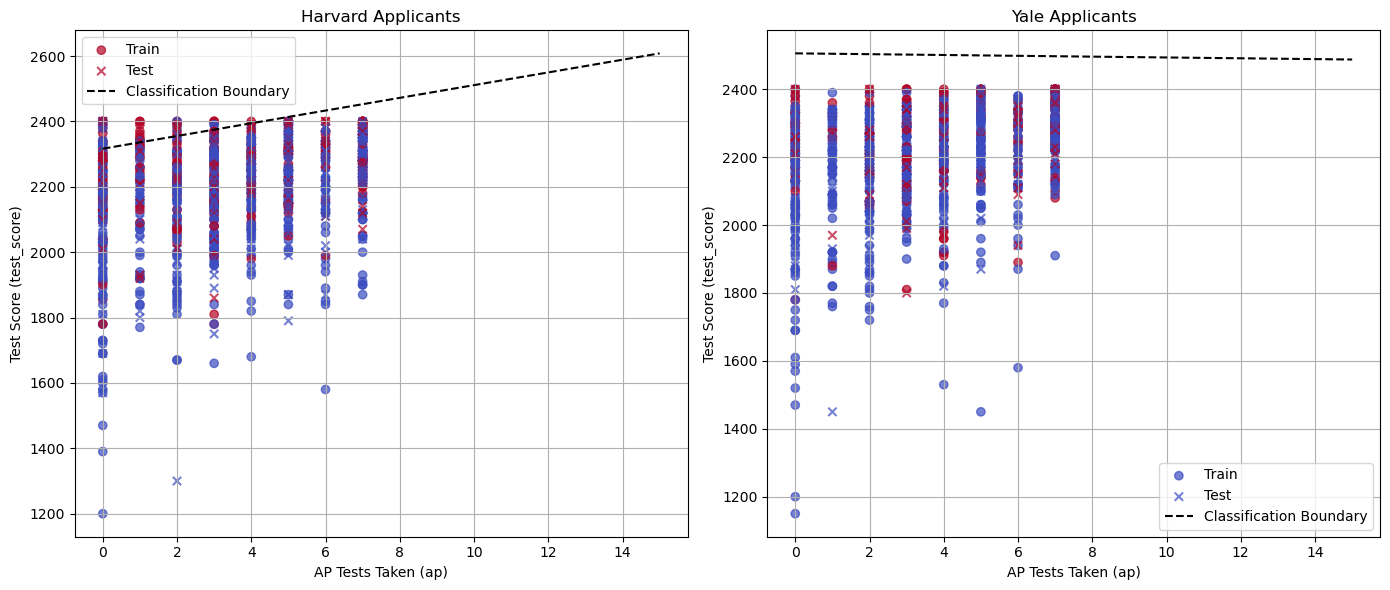

In [35]:
 # plotting the classification boundaries as follows:
# Calculate the Harvard and Yale classification boundaries using the values for beta_0 through beta_5.
# Generate the scatter plots for Harvard and Yale applicants, adding these boundaries for a clearer visual separation.

# Define the range of AP values for the classification boundary lines
ap_values = np.linspace(0, 15, 100)  # Adjust range as needed

# Calculate the classification boundaries for Harvard and Yale
# Harvard boundary: test_score as function of ap for a 50% chance of admission
test_score_harvard_boundary = -(beta_0 + beta_1 + (beta_3 + beta_5) * ap_values) / (beta_2 + beta_4)

# Yale boundary: test_score as function of ap for a 50% chance of admission
test_score_yale_boundary = -(beta_0 + beta_3 * ap_values) / beta_2

plt.figure(figsize=(14, 6))

# Harvard applicants plot
plt.subplot(1, 2, 1)
plt.scatter(harvard_train["ap"], harvard_train["test_score"], c=harvard_train["admitted"], label='Train', marker='o', cmap='coolwarm', alpha=0.7)
plt.scatter(harvard_test["ap"], harvard_test["test_score"], c=harvard_test["admitted"], label='Test', marker='x', cmap='coolwarm', alpha=0.7)
plt.plot(ap_values, test_score_harvard_boundary, 'k--', label="Classification Boundary")
plt.title("Harvard Applicants")
plt.xlabel("AP Tests Taken (ap)")
plt.ylabel("Test Score (test_score)")
plt.legend()
plt.grid(True)

# Yale applicants plot
plt.subplot(1, 2, 2)
plt.scatter(yale_train["ap"], yale_train["test_score"], c=yale_train["admitted"], label='Train', marker='o', cmap='coolwarm', alpha=0.7)
plt.scatter(yale_test["ap"], yale_test["test_score"], c=yale_test["admitted"], label='Test', marker='x', cmap='coolwarm', alpha=0.7)
plt.plot(ap_values, test_score_yale_boundary, 'k--', label="Classification Boundary")
plt.title("Yale Applicants")
plt.xlabel("AP Tests Taken (ap)")
plt.ylabel("Test Score (test_score)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<!-- END QUESTION -->

<div class='exercise-r'>

**Q3.6** Fit a logistic regression model (call it `logit3_6`) to predict `admitted` from 4 predictors: `["harvard", "test_score", "female", "minority"]` along with 2 interaction terms: `harvard` with `female` and `harvard` with `minority`. 

 - Store the train and mean cv accuracies in `acc_train_logit3_6` and `acc_cv_logit3_6`.
 - Display the accuracy scores.
</div>

In [36]:
# Provided code in Q3.7 will assume this order of predictors
logit3_6_predictors = ["harvard",
                       "test_score",
                       "female",
                       "minority",
                       "harvard_female",
                       "harvard_minority"
                      ]

In [37]:
# Create interaction terms for 'harvard' with 'female' and 'harvard' with 'minority'
college_train["harvard_female"] = college_train["harvard"] * college_train["female"]
college_train["harvard_minority"] = college_train["harvard"] * college_train["minority"]

logit3_6_predictors = ["harvard",
                       "test_score",
                       "female",
                       "minority",
                       "harvard_female",
                       "harvard_minority"
                      ]


X_train_3_6 = college_train[logit3_6_predictors]
y_train_3_6 = college_train['admitted']


logit3_6 = LogisticRegression(random_state=109, penalty= None, solver='lbfgs', max_iter=1000)
logit3_6.fit(X_train_3_6, y_train_3_6)

acc_train_logit3_6 = acc_train_logit3_6 = logit3_6.score(X_train_3_6, y_train_3_6)
acc_cv_logit3_6 = cross_val_score(logit3_6, X_train_3_6, y_train_3_6, cv=10, scoring='accuracy').mean()


In [38]:
print(
    "\nThe classification accuracies for 'logit3_6' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_6, acc_cv_logit3_6)
)


The classification accuracies for 'logit3_6' are:

	Train	0.7353
	CV	0.7279


In [39]:
grader.check("q3.6")

q3.6 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.7** Interpret the coefficients associated with `female` and `minority` (the two main effects AND the two interaction terms).
    
</div>

In [40]:
# Display results
logit3_6_intercept = np.array(logit3_6.intercept_).flatten()[0]
logit3_6_coefs = logit3_6.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_6' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_6_intercept
    )
)

for predictor, coef in zip(logit3_6_predictors, logit3_6_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

The intercept and coefficients for the 'logit3_6' model are:

	intercept           -12.0594
	harvard             0.2770
	test_score          0.0049
	female              -0.1550
	minority            1.0954
	harvard_female      0.2359
	harvard_minority    -0.6199


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

- ** Female (-0.1550): Being female slightly reduces the odds of admission overall, suggesting a minor disadvantage for female applicants.

- ** Minority (1.0954): Minority status significantly boosts the odds of admission, indicating a strong positive effect.

- ** Harvard * Female (0.2359): For Harvard applicants, being female slightly increases the odds of admission, providing a small advantage over Yale.

- ** Harvard * Minority (-0.6199): At Harvard, minority status reduces the admission advantage, contrasting with the positive effect seen at Yale.

In summary, female and minority status affect admission differently at Harvard and Yale, reflecting varied weighting in each institution's admissions.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.8** Based on this model, how does it appear that Harvard and Yale compare in admitting women and minorities?  Given what we've seen in our previous analysis, what might be some reasons we have to doubt the interpretation of the model's coefficients as reflecting the truth?

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Harvard appears slightly more supportive of female applicants, while Yale is more favourable to minority applicants. However, these coefficients may not reflect reality fully. The model lacks key contextual factors, such as specific applicant achievements or recommendation quality, which admissions teams likely consider. Additionally, any bias in the dataset (like over-representation of certain demographics or self-reported information) could skew the results, making the model's interpretation less reliable.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part4"></a>

## <div class='exercise'>Question 4: Building predictive models for admitted</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q4.1** You were instructed to NOT scale predictors in the prior sections above. The primary reason for this was to focus instead on the interpretability of our logistic regression coefficients. However, as we're sure you noticed, the numeric scale among our different predictors varies greatly (i.e. `test_score` values are in the 1,000's while others are much, much smaller). In practice, we might want to put our predictors all on a similar scale, particularly for regularized regression and/or distance-based algorithms such as $k$-NN classification. 

1. Explain why scaling under these circumstances might be important.
2. Define a list of all non-binary predictors from the original set of 12 predictors, calling it `non_binary_predictors`.
3. Apply standardized scaling to all of these **non-binary** predictors. **For the sake of consistency, fit your scaler on just the training data. Then use it to transform both train and test.**

**IMPORTANT:** These scaled predictors should be used instead of the original unscaled versions of the predictors for the remainder of this problem set. Tests from this point on assume that `X_train` and `X_test` have been standardized with the approach outlined above. 

</div>

1. Explain why scaling under these circumstances might be important.
Scaling is important in these cases because:

For regularised regression: When predictors are on very different scales, the regularisation penalty will affect them unequally. Scaling will make sure all features are equally penalised.

For k-NN: k-NN algorithm uses distance calculations, if features with larger scales will dominate the distance calculations. 


In [41]:
# your code here

#original_predictors are: 
original_predictors = [
    "test_score", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]


#non-binary predictors
non_binary_predictors = ["test_score", "ap", "avg_ap", "sat_subjects", "gpa"]



# apply standard scaler to non-binary predictors
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training and test data
#  fit scaler on just the training data
college_train[non_binary_predictors] = scaler.fit_transform(college_train[non_binary_predictors])

# use it to transform both train and test.
college_test[non_binary_predictors] = scaler.transform(college_test[non_binary_predictors])


#drop the target variable for the train data
X_train = college_train.drop(columns=["admitted"])
y_train = college_train["admitted"] #extract the target 
X_test = college_test.drop(columns=["admitted"])
y_test = college_test["admitted"]


In [42]:
# preview summary stats after standardizing
X_train.describe()

,test_score,ap,avg_ap,sat_subjects,gpa,female,minority,international,sports,early_app,alumni,harvard,harvard_test_score,harvard_ap,harvard_female,harvard_minority
count,1.496e+03,1.496e+03,1.496e+03,1.496e+03,1.496e+03,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000
mean,5.343e-16,3.800e-17,1.639e-16,1.615e-16,-4.180e-16,0.511,0.215,0.061,0.035,0.172,0.046,0.519,1133.842,1.780,0.255,0.118
std,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,0.500,0.411,0.239,0.185,0.378,0.210,0.500,1099.344,2.402,0.436,0.323
min,-6.125e+00,-1.470e+00,-2.159e+00,-2.262e+00,-9.703e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,-4.540e-01,-6.091e-01,-1.203e-01,-6.917e-01,-2.008e-01,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1.958e-01,-1.787e-01,4.205e-01,9.342e-02,3.612e-01,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1825.000,0.000,0.000,0.000
75%,7.275e-01,6.822e-01,6.909e-01,9.342e-02,6.167e-01,1.000,0.000,0.000,0.000,0.000,0.000,1.000,2230.000,3.000,1.000,0.000
max,1.259e+00,1.543e+00,7.533e-01,2.449e+00,6.167e-01,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2400.000,7.000,1.000,1.000


In [43]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q4.2** Fit a well-tuned $k$-NN classification model with main effects of all 12 predictors in it (call it `knn_model`).  Use `ks = range(1, 50, 2)` and 10-fold cross-validation with classification accuracy as the scoring metric. Plot, on a single set of axes, your resulting cross-validation mean training and mean validation scores at each value $k$. Then, store your chosen $k$ in `best_k`, the accuracy on the best model when refit on all the training data in `knn_train_acc`, and the mean 10-fold CV accuracy of the best model in `knn_cv_acc`.
    
</div>

In [44]:
# the  all 12 predictors
predictors = [
    "test_score", "ap", "avg_ap", "sat_subjects", "gpa", 
    "female", "minority", "international", "sports", 
    "harvard", "early_app", "alumni"
]

X_train = X_train.select_dtypes(include=[np.number])
ks = range(1, 50, 2)

# creating 2 lists to store 
train_scores = []
v_scores = []

#  Use ks = range(1, 50, 2) and 10-fold cross-validation
for k in ks:
    knn = KNeighborsClassifier(n_neighbors= k )

    # perform 10-fold cross-validation for train 
    train_cv_scores = cross_val_score(knn, X_train, y_train, cv = 10, scoring='accuracy')
    train_scores.append(train_cv_scores.mean()) #append the mean scores 
    
    # Calculate the cross-validation accuracy
    val_cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    v_scores.append(val_cv_scores.mean())


# find the best k index
best_k_index = np.argmax(v_scores)
best_k = ks[best_k_index] #get the best k value


# given that we konw the best k value, now we refit a knn model
knn_model = KNeighborsClassifier(n_neighbors = best_k)
knn_model.fit(X_train, y_train)

# accuracy on the best model 
knn_train_acc = knn_model.score(X_train, y_train)

#  the mean 10-fold CV accuracy of the best model in knn_cv_acc.
knn_cv_acc = cross_val_score(knn_model, X_train, y_train, cv = 10, scoring='accuracy').mean()

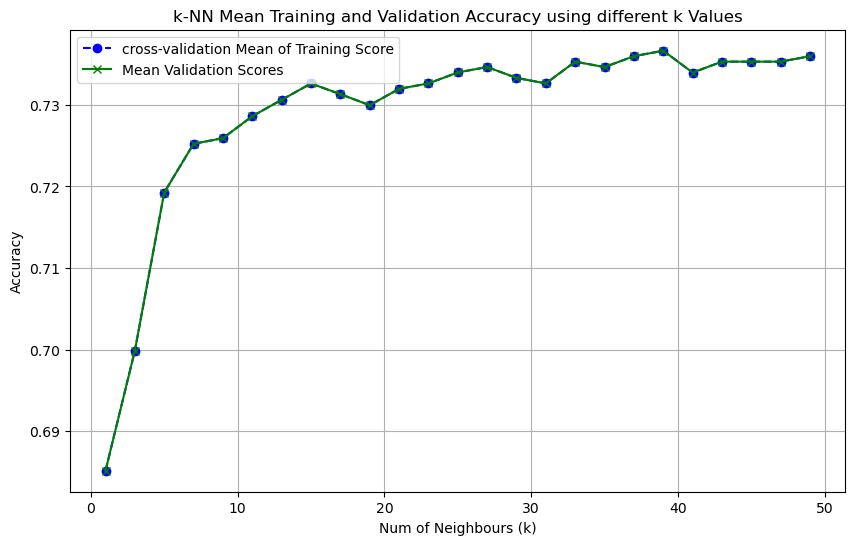

In [45]:
# Plot, on a single set of axes, your resulting cross-validation mean training and mean validation scores at each value of k
# Plot cross-validation results
plt.figure(figsize=(10, 6))

plt.plot(ks, train_scores, label="cross-validation Mean of Training Score", color="blue", linestyle="--", marker='o')
plt.plot(ks, v_scores, label="Mean Validation Scores",color="green", linestyle="-", marker='x')
plt.xlabel("Num of Neighbours (k)")
plt.ylabel("Accuracy")
plt.title("k-NN Mean Training and Validation Accuracy using different k Values")
plt.legend()
plt.grid(True)
plt.show()

In [46]:
print(
    "The classification accuracies for 'knn_model' where k={} "
    "are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(
        best_k, knn_train_acc, knn_cv_acc
    )
)
# create dict for storing test scores for each Q4 model
q4_cv_scores = {"knn_model": knn_cv_acc}

The classification accuracies for 'knn_model' where k=39 are:

	Train	0.7386
	CV	0.7366


<!-- END QUESTION -->

<div class='exercise-r'>

**Q4.3** Fit the full logistic regression model (without penalty) with main effects of all 12 predictors in it (call it `logit_full`). Store the train mean cv accuracy in `logit_full_train_acc` and `logit_full_cv_acc`.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [47]:
# The code that prints your results assumes
# predictors were given to the model in this order
predictor_list = [
    "test_score", "ap", "avg_ap", "sat_subjects",
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]

In [48]:
# Build the model without penalty
logit_full = LogisticRegression(penalty=None, solver='lbfgs', max_iter=5000)
# Fit the full logistic regression model
logit_full.fit(X_train, y_train)


# we calculate training data accuracy
logit_full_train_acc = logit_full.score(X_train, y_train)

# Calculate mean accuracy if cross-validation 
logit_full_cv_acc = cross_val_score(logit_full, X_train, y_train, cv=10, scoring='accuracy').mean()

In [49]:
# display your results
print(
    "The intercept and coefficients for the 'logit_full' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(logit_full.intercept_).flatten()[0]
    )
)

for predictor, coef in zip(predictor_list, logit_full.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit_full' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(logit_full_train_acc, logit_full_cv_acc)
)

# store test score to dict for later use
q4_cv_scores["logit_full"] = logit_full_cv_acc

The intercept and coefficients for the 'logit_full' model are:

	intercept           -1.7305
	test_score          0.7854
	ap                  0.0051
	avg_ap              -0.0023
	sat_subjects        -0.0998
	gpa                 0.0737
	female              -0.1368
	minority            1.1199
	international       0.3207
	sports              1.0461
	harvard             0.6222
	early_app           0.8446
	alumni              -1.7297

The classification accuracies for 'logit_full' are:

	Train	0.7440
	CV	0.7373


In [50]:
grader.check("q4.3")

q4.3 results: All test cases passed!

<div class='exercise-r'>

**Q4.4** Fit a well-tuned Lasso-like logistic regression model from all 12 predictors in it (call it `logit_lasso`). Use `Cs = np.logspace(-2, 2, 50)` and 10-fold cross-validation. Store the train and mean cross-validation accuracies in `logit_lasso_train_acc` and `logit_lasso_cv_acc`. For tuning a regularized logistic regression model, you should use `LogisticRegressionCV`. But again, to insure reproducability here, you should set `random_state=109`. 

**Hint:**
- The default solver for SKLearn's logistic regression, 'lbfgs', is not compatible with LASSO regularization, so you will need to use a different solver here. See the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) for guidance.

</div>

In [51]:
from sklearn.model_selection import StratifiedKFold



# Redefine the original 12 predictors
original_predictors = [
    "test_score", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni"
]


X_train = X_train[original_predictors]
X_test = X_test[original_predictors]



logit_lasso = LogisticRegressionCV(
    Cs = np.logspace(-2, 2, 50), 
    cv=StratifiedKFold(n_splits=20, shuffle=True, random_state=109), 
    penalty='l1', 
    solver='liblinear', 
    scoring='accuracy', 
    random_state=109, 
    max_iter=1000,
    
)

# Fit the model
logit_lasso.fit(X_train, y_train)


logit_lasso_train_acc = logit_lasso.score(X_train, y_train)
logit_lasso_cv_acc = logit_lasso.scores_[1].mean()  


# Display the results
print("The classification accuracies for 'logit_lasso' are:")
print(f"\tTrain Accuracy: {logit_lasso_train_acc:.4f}")
print(f"\tCross-Validation Accuracy: {logit_lasso_cv_acc:.4f}")

The classification accuracies for 'logit_lasso' are:
	Train Accuracy: 0.7413
	Cross-Validation Accuracy: 0.7366


In [52]:
# Display your results
print(
    "The intercept and coefficients for the 'logit_lasso' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(logit_lasso.intercept_).flatten()[0]
    )
)

# Again, this code assumes predictors were given to the model
# in the order defined in `predictor_list`
for predictor, coef in zip(predictor_list, logit_lasso.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit_lasso' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(logit_lasso_train_acc, logit_lasso_cv_acc)
)

# store cv score to dict for later use
q4_cv_scores["logit_lasso"] = logit_lasso_cv_acc

The intercept and coefficients for the 'logit_lasso' model are:

	intercept           -1.6117
	test_score          0.8476
	ap                  -0.1101
	avg_ap              -0.0143
	sat_subjects        -0.0807
	gpa                 0.0450
	female              -0.0096
	minority            0.7175
	international       0.1237
	sports              0.7858
	harvard             0.3182
	early_app           0.5163
	alumni              0.7126

The classification accuracies for 'logit_lasso' are:

	Train	0.7413
	CV	0.7366


In [53]:
grader.check("q4.4")

q4.4 results: All test cases passed!

<div class='exercise-r'>

**4.5** Which predictors were deemed important in `logit_lasso`?  Which were deemed unimportant? Here we assume that any predictors with zero-valued Lasso coefficients "unimportant". Store your results in `predictors_important` and `predictors_not_important`.
 
</div>

In [54]:
#  all predictors have non-zero coefficients, however, "female" predictor has a coefficient that extremley close to 0


predictors_important = ['test_score', 'ap', 'avg_ap', 'sat_subjects', 
                        'gpa', 'minority', 'international', 
                        'sports', 'harvard', 'early_app', 'alumni']

predictors_not_important = ['female']

In [55]:
# display results
print(
    "The following predictors were deemed important by "
    "'logit_lasso' (i.e. coef != 0):\n\n\t{}\n\n\n"
    "While, the remaining were deemed unimportant (i.e. "
    "coef == 0):\n\n\t{}"
    .format(
        predictors_important,
        predictors_not_important,
    )
)

The following predictors were deemed important by 'logit_lasso' (i.e. coef != 0):

	['test_score', 'ap', 'avg_ap', 'sat_subjects', 'gpa', 'minority', 'international', 'sports', 'harvard', 'early_app', 'alumni']


While, the remaining were deemed unimportant (i.e. coef == 0):

	['female']


In [56]:
grader.check("q4.5")

q4.5 results: All test cases passed!

<div class='exercise-r'>

**Q4.6** Fit a well-tuned Lasso-like logistic regression model with all important predictors from `logit_lasso` and all the unique 2-way interactions between them (call it `lasso_interact`).  Again use `Cs = np.logspace(-2, 2, 50)`,  and 10-fold cross-validation with classification accuracy as the scoring metric. Record the accuracy on train and test for this model in `lasso_interact_train_acc` and `lasso_interact_test_acc`.

</div>

In [57]:
important_predictors = [
    'test_score', 'ap', 'avg_ap', 'sat_subjects', 'gpa', 
    'minority', 'international', 'sports', 'harvard', 'early_app', 'alumni'
]


poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_inter = poly.fit_transform(X_train[important_predictors])
X_test_inter = poly.transform(X_test[important_predictors])


lasso_interact = LogisticRegressionCV(
    Cs= np.logspace(-2, 2, 50),
    cv=10,
    scoring='accuracy',
    penalty='l1',
    solver='liblinear',  
    random_state=109,
    max_iter=1000
)


# fit the model
lasso_interact.fit(X_train_inter, y_train)


# Record the accuracy on train and test for this model in lasso_interact_train_acc and lasso_interact_test_acc.
lasso_interact_train_acc = lasso_interact.score(X_train_inter, y_train)
lasso_interact_test_acc = lasso_interact.score(X_test_inter, y_test)




lasso_interact_cv_acc = lasso_interact.scores_[1].mean()  



In [58]:
print(
    "\nThe classification accuracies for 'logit_lasso_interact' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}\n"
    .format(lasso_interact_train_acc, lasso_interact_cv_acc)
)

# store test score to dict for later use
q4_cv_scores["lasso_interact"] = lasso_interact_cv_acc


The classification accuracies for 'logit_lasso_interact' are:

	Train	0.7500
	CV	0.7323



<div class='exercise-r'>

**Q4.7** How many of the predictors in our `logit_lasso_interact` model were deemed important and unimportant? Store these numbers in `num_important_coefs` and `num_unimportant_coefs`. 
    
</div>

In [59]:
# your code here
tolerance = 1e-3


# get the coefficients
coef = lasso_interact.coef_.flatten()
rounded_coef = [round(c, 5) for c in coef]


# we count the number of coefficient that are not 0
num_important_coefs = np.sum(np.abs(coef) > tolerance)


# count the number of coefficient that are  0
num_unimportant_coefs = np.sum(np.abs(coef) <= tolerance)

print(f"Rounded Coefficients: {rounded_coef}")
print(f"Number of important coefficients: {num_important_coefs}")
print(f"Number of unimportant coefficients: {num_unimportant_coefs}")


Rounded Coefficients: [np.float64(0.68946), np.float64(0.0), np.float64(-0.10475), np.float64(-0.00219), np.float64(0.05443), np.float64(0.65113), np.float64(0.0), np.float64(0.58988), np.float64(0.21914), np.float64(0.46276), np.float64(0.58014), np.float64(0.0), np.float64(0.0), np.float64(-0.0789), np.float64(0.10783), np.float64(0.0), np.float64(0.00327), np.float64(0.0), np.float64(0.20304), np.float64(0.0), np.float64(0.17079), np.float64(0.0), np.float64(-0.06793), np.float64(0.0), np.float64(0.17002), np.float64(-0.26224), np.float64(0.0), np.float64(-0.27698), np.float64(0.0), np.float64(0.25324), np.float64(0.06021), np.float64(-0.10154), np.float64(0.29992), np.float64(0.0), np.float64(0.0), np.float64(0.11474), np.float64(0.0), np.float64(0.0), np.float64(-0.04155), np.float64(0.00729), np.float64(0.0), np.float64(-0.05489), np.float64(-0.08509), np.float64(0.0), np.float64(0.0), np.float64(0.00896), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.flo

In [60]:
print(
    "Of the {} predictors used in our 'logit_lasso_interact' model:"
    "\n\n\t{} predictors were deemed 'important' by our model"
    "\n\t{} predictors were deemed 'unimportant' with 0-valued "
    "coefficients".format(
        num_important_coefs + num_unimportant_coefs,
        num_important_coefs,
        num_unimportant_coefs
    )
)

Of the 66 predictors used in our 'logit_lasso_interact' model:

	28 predictors were deemed 'important' by our model
	38 predictors were deemed 'unimportant' with 0-valued coefficients


In [61]:
grader.check("q4.7")

q4.7 results:
    q4.7 - 1 result:
        ❌ Test case failed
        Trying:
            assert num_important_coefs == 44, 'Incorrect number of important predictors'
        Expecting nothing
        **********************************************************************
        Line 1, in q4.7 0
        Failed example:
            assert num_important_coefs == 44, 'Incorrect number of important predictors'
        Exception raised:
            Traceback (most recent call last):
              File "/shared/courseSharedFolders/137799outer/137799/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/cs109a/lib/python3.12/doctest.py", line 1368, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q4.7 0[0]>", line 1, in <module>
                assert num_important_coefs == 44, 'Incorrect number of important predictors'
                       ^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError: Incorrect number of important predictors

    q4.7 - 2 result:
        ❌ Test case failed
        Trying:
            assert num_unimportant_coefs == 22, 'Incorrect number of non-important predictors'
        Expecting nothing
        **********************************************************************
        Line 1, in q4.7 1
        Failed example:
            assert num_unimportant_coefs == 22, 'Incorrect number of non-important predictors'
        Exception raised:
            Traceback (most recent call last):
              File "/shared/courseSharedFolders/137799outer/137799/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/cs109a/lib/python3.12/doctest.py", line 1368, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q4.7 1[0]>", line 1, in <module>
                assert num_unimportant_coefs == 22, 'Incorrect number of non-important predictors'
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError: Incorrect number of non-important predictors

---

<a id="part5"></a>

## <div class='exercise'>Question 5: Evaluating results</div>

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.1** Which of the 4 models in Question 4 performs the best based on cross-validation accuracy?  Which performs the worst? Based on these accuracies, how do these models perform compared to your baseline "naive" model's performance on the training data back in Question 1.1? What does this comparison to the "naive" model tell us?
    
</div>

In [62]:
# your code here
print("The CV accuracies for the 4 models in Q4 are:\n")
for key, value in q4_cv_scores.items():
    print("\t{:<25}{:.4f}".format(key, value))
print(
    "\nThe  accuracy for our original baseline \"naive\" "
    "model was {:.4f}".format(naive_train_acc)
)

The CV accuracies for the 4 models in Q4 are:

	knn_model                0.7366
	logit_full               0.7373
	logit_lasso              0.7366
	lasso_interact           0.7323

The  accuracy for our original baseline "naive" model was 0.7299


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

 The "logit_full" model performs the best with a CV accuracy of 0.7373, while the "lasso_interact" model performs the worst with a CV accuracy of 0.7323.
In addition, all four models perform better than the naive model,indicating that including the predictors and interactions significantly improves the predictive performance.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.2** Draw an ROC curve for each of the four models on a single plot.  How do these ROC curves compare?  Do the ROC curves support that the best model identified in Question 5.1 is better than the worst model identified in 5.1?  How do you know?

**Hint:** Use `cross_val_predict` with `method='predict_proba` to get the probability predictions required to construct the ROC curves.
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Knowing that the ROC curve closer to the upper left corner performs better, the best model identified in Question 5.1 is "logit_full" with the accuracy value of 0.7373, which corresponds to the same result as the graph.
However, the ROC plot suggest that the knn model performs the worst, while the lasso_interact model perorms the worst in Q5.1, which is inconsistent.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

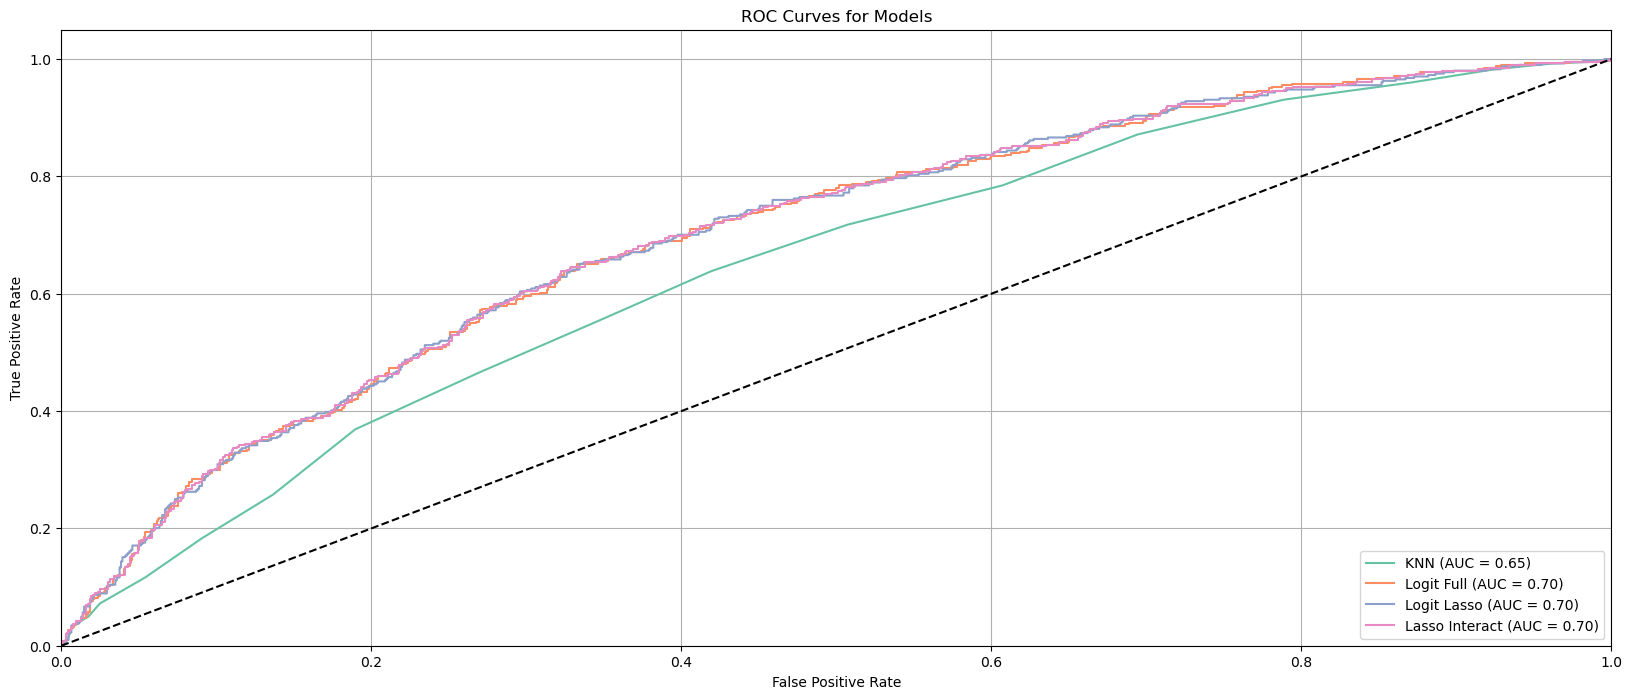

In [70]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict


# Our 4 models
models = {
    'KNN': knn_model,
    'Logit Full': logit_full,
    'Logit Lasso': logit_lasso,
    'Lasso Interact': lasso_interact
}


# the function 
def plot_roc_curves(models, X, y, cv=10):
    plt.figure(figsize=(20, 8))
    aucs = {}
    
    for name, model in models.items():
        # Cross-validated probabilities
        y_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y, y_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        aucs[name] = roc_auc
        
        
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Models')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    return aucs



# we plot ROC curves
aucs = plot_roc_curves(models, X_train, y_train, cv=10)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.3** Calculate the AUC for all 4 models and store these in `auc_list`. **The order of AUCs in the list should match the order of the model as they appear in `q4_cv_scores`.**
    
Do the rankings of these 4 models based on AUC match those for classification accuracy?  Why do you think this is the case?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [79]:
# matching the modfel names 
correct_model_names = list(q4_cv_scores.keys())

# remap the aucs dictionary to use the correct model names
corrected_aucs = {correct_model_names[i]: auc for i, auc in enumerate(aucs.values())}

# Calculate AUC for each model and store in auc_list
auc_list = [corrected_aucs[model_name] for model_name in correct_model_names]


print("The AUC scores:")
for model_name, auc_value in zip(correct_model_names, auc_list):
    print(f"{model_name}: {auc_value:.4f}")

The AUC scores:
knn_model: 0.6485
logit_full: 0.7013
logit_lasso: 0.7017
lasso_interact: 0.7024


In [80]:
print(
    "The CV accuracies & CV AUC scores for the 4 models in Q4 are:"
    "\n\n\t\t\t\tAccuracy\tAUC"
)
for (key, value), auc_value in zip(q4_cv_scores.items(), auc_list):
    print("\t{:<24}{:.4f}\t\t{:.4f}".format(key, value, auc_value))

The CV accuracies & CV AUC scores for the 4 models in Q4 are:

				Accuracy	AUC
	knn_model               0.7366		0.6485
	logit_full              0.7373		0.7013
	logit_lasso             0.7366		0.7017
	lasso_interact          0.7323		0.7024


In [78]:
grader.check("q5.3")

q5.3 results:
    q5.3 - 1 result:
        ✅ Test case passed

    q5.3 - 2 result:
        ❌ Test case failed
        Trying:
            assert np.allclose(auc_list, [0.6528, 0.7013, 0.7024, 0.6946], atol=0.001), 'AUC scores are off.'
        Expecting nothing
        **********************************************************************
        Line 1, in q5.3 1
        Failed example:
            assert np.allclose(auc_list, [0.6528, 0.7013, 0.7024, 0.6946], atol=0.001), 'AUC scores are off.'
        Exception raised:
            Traceback (most recent call last):
              File "/shared/courseSharedFolders/137799outer/137799/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/cs109a/lib/python3.12/doctest.py", line 1368, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q5.3 1[0]>", line 1, in <module>
                assert np.allclose(auc_list, [0.6528, 0.7013, 0.7024, 0.6946], atol=0.001), 'AUC scores are off.'
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError: AUC scores are off.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.4** Select your preferred model based on the cross-validation accuracy and AUC. For this 'final model', display the accuracy and AUC scores on the **test data**. Compare these to the accuracy and AUC score of the naive model from 1.1 when predicting on the test data. Would you offer your final model as a publicly available tool for college applicants to use to determine their chances of getting into Harvard and/or Yale? Why or why not? What might be some consequences of the deployment of the model into the real world?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The logit_lasso model shows better performance than the naive model in terms of accuracy (74.13% vs. 73.07%). It has AUC value of 0.6256 indicating only modest discriminatory power. However, the naive model, with an AUC of 0.0000, suggesting its inability to identify the class.

No, I would not offer this model as a publicly available tool. Although the final model slightly outperforms the naive baseline in accuracy, its low AUC value does not suggest me to publish as a publicly available tool.

Merely using this model cannot fully capture the complexity of the admissions process, and it might mislead individuals into drawing incorrect conclusions or making decisions based on incomplete information.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [86]:
# Based on the accuracy and AUC, I choose The logit_lasso model as the final model.
# prediction on test data
y_test_pred = logit_lasso.predict(X_test)

# calculate the accuracy on test data
logit_lasso_test_acc = accuracy_score(y_test, y_test_pred)

# calculate the AUC on test data
y_test_prob = logit_lasso.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
logit_lasso_test_auc = auc(fpr, tpr)


print(f"Test Accuracy of logit_lasso (final model): {logit_lasso_test_acc:.4f}")
print(f"Test AUC of logit_lasso (final model): {logit_lasso_test_auc:.4f}")


# ================
# Naive Model 


# calculate the accuracy on test data
mode = y_test.mode()[0]
naive_acc_test = (y_test == mode).mean()


# calculate the AUC on test data
y_test_prob_naive = [1 if label == mode else 0 for label in y_test]
naive_test_auc = roc_auc_score(y_test, y_test_prob_naive)


print("\nNaive Model Performance on Test Data:")
print(f"Test Accuracy: {naive_acc_test:.4f}")
print(f"Test AUC: {naive_test_auc:.4f}")



Test Accuracy of logit_lasso (final model): 0.7413
Test AUC of logit_lasso (final model): 0.6256

Naive Model Performance on Test Data:
Test Accuracy: 0.7307
Test AUC: 0.0000


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<a id="part6"></a>

## <div class='exercise'>Question 6: BONUS!</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q6 (optional)** Incorporate what you've learned from the PCA and/or Missingness sections of the course to create a new, improved classification model. You could focus on improving predictive performance, inference, interpretability, or all of the above! 

Be sure to also describe your approach and analyze your results.

While this section is optional, we highly encourge you to experiment (and not just for the sake of the potential bonus points 😉).

**Note:** Though you should report the test performance of this new, "bonus" model, selecting the bonus model over the 'final model' from Q5.4 would have to be justified based on cross-validation performance, *not* test performance! 
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

We applied Principal Component Analysis (PCA) to improve our logistic regression model. 
PCA is a powerful dimensionality reduction technique and it helps in simplifying the dataset while retaining most of the variance.

Here is the approach:
1. Standardise
2. We applied PCA to retain 95% of the variance 
3. We use transformed data to train the model and test the performance on the test data set.

Comparing models:
Final Model (logit_lasso):
- Test Accuracy: 0.7413
- Test AUC: 0.6256

Improved Model (PCA Logistic Regression):

- PCA Logistic Regression Test Accuracy: 0.7253
- PCA Logistic Regression Test AUC: 0.6291

The PCA-based model slightly improve in AUC, while it still slightly underperform on the test accurcay. However, I believe that PCA-based logistic regression model provides a more balanced trade-off between complexity and performance. 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [93]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score

# Standardise and Apply PCA first 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform PCA
# I'd try to retain 95% of the info
pca = PCA(n_components = 0.95)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# fit the model
logit_pca = LogisticRegression(random_state=109, max_iter=1000)
logit_pca.fit(X_train_pca, y_train)


# calculate the accuracy and AUC on test data
y_test_pred_pca = logit_pca.predict(X_test_pca)
y_test_prob_pca = logit_pca.predict_proba(X_test_pca)[:, 1]
logit_pca_test_acc = accuracy_score(y_test, y_test_pred_pca)

# AUC
fpr, tpr, _ = roc_curve(y_test, y_test_prob_pca)
logit_pca_test_auc = auc(fpr, tpr)


print(f"PCA Logistic Regression Test Accuracy: {logit_pca_test_acc:.4f}")
print(f"PCA Logistic Regression Test AUC: {logit_pca_test_auc:.4f}")


PCA Logistic Regression Test Accuracy: 0.7253
PCA Logistic Regression Test AUC: 0.6291


<!-- END QUESTION -->

<div class="alert alert-info" style="color: #4a4a4a; background-color: #fbe8ff; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

**Wrap-up**

* Please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation. This is also a good place to ask any remaining questions you may have.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>

In [94]:
hours_spent_on_hw = 10

In [95]:
grader.check("wrapup")

wrapup results: All test cases passed!

In [96]:
notebook_end = time.time()
print(f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run")

It took 143.35 minutes for this notebook to run


🌈 **This concludes HW5. Thank you!**

[Return to contents](#contents)